In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "lines.linewidth": 1.5,
    "lines.markersize": 5,
    "axes.linewidth": 1,
})

tf.random.set_seed(1234)
np.random.seed(1234)

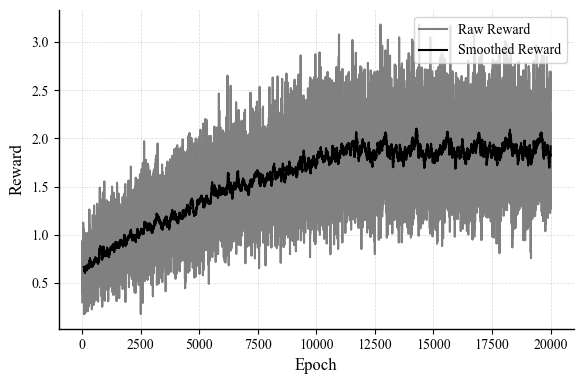

In [ ]:
'''

Upgraded version: PPO + Using q-batches + Curriculum learning.

'''

def get_bounds_from_csv(filename):
    df = pd.read_csv(filename)
    nu_min = df['Nu'].min()
    nu_max = df['Nu'].max()
    dp_min = df['dP'].min()
    dp_max = df['dP'].max()
    return (nu_min, nu_max), (dp_min, dp_max)

bounds = {
    0: {  # eg
        'nu': get_bounds_from_csv("cooling_eg.csv")[0],
        'dp': get_bounds_from_csv("cooling_eg.csv")[1]
    },
    1: {  # water
        'nu': get_bounds_from_csv("cooling_water.csv")[0],
        'dp': get_bounds_from_csv("cooling_water.csv")[1]
    },
    2: {  # air
        'nu': get_bounds_from_csv("cooling_air.csv")[0],
        'dp': get_bounds_from_csv("cooling_air.csv")[1]
    }
}

class CurriculumScheduler:
    def __init__(self, max_episode):
        self.max_episode = max_episode

    def get_q_bounds(self, episode):
        fraction = min(episode / self.max_episode, 1.0)
        center = 0.5
        width = fraction * 0.5  # Expands from 0 to full range
        q_min = max(0.0, center - width)
        q_max = min(1.0, center + width)
        return q_min, q_max


class PPOActor(Model):
    def __init__(self, input_dim, output_dim):
        super(PPOActor, self).__init__()
        self.hidden = [
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh')
        ]
        self.mean = layers.Dense(output_dim, activation='sigmoid')  # for continuous actions
        self.log_std = tf.Variable(tf.zeros(output_dim), trainable=True)  # learnable std

    def call(self, state):
        x = state
        for layer in self.hidden:
            x = layer(x)
        return self.mean(x), self.log_std

class PPOCritic(Model):
    def __init__(self, input_dim):
        super(PPOCritic, self).__init__()
        self.hidden = [
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh'),
            layers.Dense(64, activation='tanh')
        ]
        self.value = layers.Dense(1)

    def call(self, state):
        x = state
        for layer in self.hidden:
            x = layer(x)
        return self.value(x)


def sample_action(mean, log_std):
    std = tf.exp(log_std)
    dist = tf.random.normal(shape=mean.shape) * std + mean
    action = tf.clip_by_value(dist, 0, 1)  # since output is sigmoid
    return action, dist, std

def get_reward(action_batch, q_batch, models):
    Re = action_batch[:, 0:1]
    cps = action_batch[:, 1:5]
    mi_logits = action_batch[:, 5:]
    mi_indices = tf.argmax(mi_logits, axis=1)

    input_vecs = tf.concat([cps, Re, tf.reshape(q_batch, (-1,1))], axis=1)

    pred_nu = []
    pred_dp = []

    for i in range(len(models)):
        idx = tf.where(mi_indices == i)[:, 0]
        if tf.shape(idx)[0] == 0:
            continue
        selected_inputs = tf.gather(input_vecs, idx)
        output = models[i](selected_inputs, training=False)
        
        # Denormalize
        nu_min, nu_max = bounds[i]['nu']
        dp_min, dp_max = bounds[i]['dp']

        nu = output[:, 0] * (nu_max - nu_min) + nu_min
        dp = output[:, 1] * (dp_max - dp_min) + dp_min

        pred_nu.append((idx, nu))
        pred_dp.append((idx, dp))

    # Reassemble the batch outputs
    final_nu = tf.TensorArray(tf.float32, size=tf.shape(action_batch)[0])
    final_dp = tf.TensorArray(tf.float32, size=tf.shape(action_batch)[0])

    for idx, nu in pred_nu:
        final_nu = final_nu.scatter(idx, nu)
    for idx, dp in pred_dp:
        final_dp = final_dp.scatter(idx, dp)

    nu_tensor = final_nu.stack()
    dp_tensor = final_dp.stack()

    dp_safe = tf.where(dp_tensor > 1e-4, dp_tensor, 1e-4)
    
    reward = tf.math.log(nu_tensor / dp_safe**(1/3) + 1e-4)
    return tf.reshape(reward, (-1, 1))


actor = PPOActor(input_dim=1, output_dim=8)
critic = PPOCritic(input_dim=1)

actor_optimizer = tf.keras.optimizers.Adam(5e-4)
critic_optimizer = tf.keras.optimizers.Adam(3e-4)

model_eg, model_water, model_air = load_model("model_eg.keras"), load_model("model_water.keras"), load_model("model_air.keras")
models = [model_eg, model_water, model_air]
eps_clip = 0.2
gamma = 1.0  # stateless
epochs = 10
batch_size = 64
episodes = 20000

all_returns = []

curriculum = CurriculumScheduler(5000)

for episode in range(episodes):
    batch_q_flux_size = 32
    q_min, q_max = curriculum.get_q_bounds(episode)
    q_batch = np.random.uniform(q_min, q_max, size=(batch_q_flux_size, 1)).astype(np.float32)

    state_batch = tf.convert_to_tensor(q_batch)

    with tf.GradientTape(persistent=True) as tape:
        mean, log_std = actor(state_batch)
        action, dist, std = sample_action(mean, log_std)

        rewards = get_reward(action, q_batch, models)

        values = critic(state_batch)
        advantages = rewards - values

        log_prob_old = -0.5 * tf.reduce_sum(((action - mean) / std)**2 + 2 * log_std + tf.math.log(2*np.pi), axis=1)

        new_mean, new_log_std = actor(state_batch)
        new_std = tf.exp(new_log_std)
        log_prob = -0.5 * tf.reduce_sum(((action - new_mean) / new_std)**2 + 2 * new_log_std + tf.math.log(2*np.pi), axis=1)

        ratio = tf.exp(log_prob - log_prob_old)
        surr1 = ratio * advantages
        surr2 = tf.clip_by_value(ratio, 1 - eps_clip, 1 + eps_clip) * advantages
        actor_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
        critic_loss = tf.reduce_mean((rewards - values) ** 2)

    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    actor_optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
    critic_optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
    
    rew = tf.reduce_mean(rewards).numpy()
    all_returns.append(rew)

    # if episode % 100 == 0:
    #     print(f"[Ep {episode}] Reward: {rew:.4f} q_range=({q_min:.2f}, {q_max:.2f})")

all_returns = np.array(all_returns)

def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
smoothed = moving_average(all_returns, window_size=50)

actor.save("ppo2_actor.keras")
critic.save("ppo2_critic.keras")

# --- Plot ---
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(all_returns, label='Raw Reward', color='gray', linestyle='-')
ax.plot(range(50 - 1, len(all_returns)), smoothed, label='Smoothed Reward', color='black', linestyle='-')

ax.set_xlabel('Epoch')
ax.set_ylabel('Reward')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right')

plt.savefig("PPO_Rewards.png", dpi=600, bbox_inches='tight')
plt.tight_layout()
plt.show()
